# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import deeplake
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

# Modify classifier for CIFAR-10
vgg16.classifier[6] = torch.nn.Linear(4096, 7)

# Freezing backbone for finetuining
for param in vgg16.parameters():
    param.requires_grad = False

for param in vgg16.classifier.parameters():
    param.requires_grad = True

for name, param in vgg16.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# Transformations
transform = transforms.Compose([
    transforms.Resize(224),  # resize to default vgg16 input size
    transforms.ToTensor(),
])

# Loading PACS
ds_train = deeplake.load("hub://activeloop/pacs-train")
ds_test = deeplake.load("hub://activeloop/pacs-test")


train_loader = ds_train.pytorch(num_workers=1, batch_size=128, decode_method={"images": "pil"}, transform={'images': transform, 'labels': None}, shuffle=True)
test_loader = ds_test.pytorch(num_workers=1, batch_size=128, decode_method={"images": "pil"}, transform={'images': transform, 'labels': None}, shuffle=True)


/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train



/

hub://activeloop/pacs-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test



\

hub://activeloop/pacs-test loaded successfully.



In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-4)

In [5]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set model to training mode

    # Lists to store loss and accuracy values for each epoch
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Wrap train_loader with tqdm for progress tracking
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for batch in train_loader:
                # Access images and labels from the batch
                inputs = batch['images'].to(device)  # Move images to the appropriate device
                labels = batch['labels'].to(device)  # Move labels to the appropriate device
                labels = labels.squeeze(1)
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Update the progress bar
                pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=100. * correct / total)
                pbar.update(1)

        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        accuracy = 100. * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Plot the training loss and accuracy graphs
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(1, num_epochs + 1), epoch_losses, color='tab:red', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Accuracy (%)', color='tab:blue')  # we already handled the x-label with ax1
    ax2.plot(range(1, num_epochs + 1), epoch_accuracies, color='tab:blue', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title("Training Loss and Accuracy over Epochs")
    plt.show()

Epoch 3/3: 100%|██████████| 71/71 [01:13<00:00,  1.03s/batch, accuracy=91.9, loss=0.233]


Epoch 3/3, Loss: 0.2330, Accuracy: 91.88%


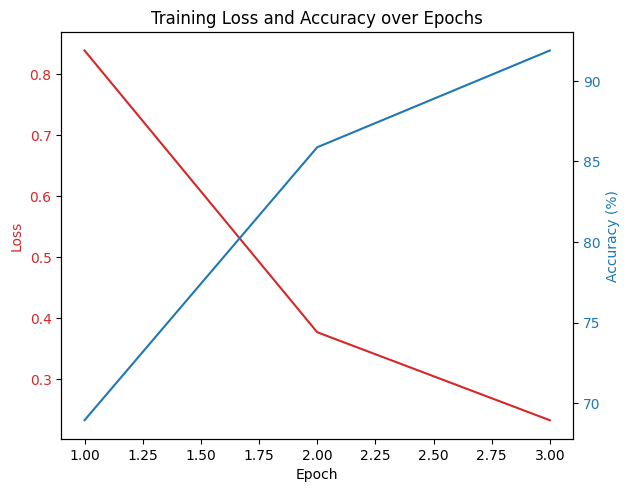

In [6]:
train_model(vgg16, train_loader, criterion, optimizer, num_epochs=3)

In [7]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # List to store individual accuracies for each batch (optional)
    batch_accuracies = []

    with torch.no_grad():
        # Wrap test_loader with tqdm for progress tracking
        with tqdm(total=len(test_loader), desc='Evaluating', unit='batch') as pbar:
            for batch in test_loader:
                # Access images and labels from the batch
                inputs = batch['images'].to(device)  # Move images to the appropriate device
                labels = batch['labels'].to(device)  # Move labels to the appropriate device
                labels = labels.squeeze(1)

                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Calculate accuracy for the current batch (optional)
                batch_accuracy = 100. * predicted.eq(labels).sum().item() / labels.size(0)
                batch_accuracies.append(batch_accuracy)

                # Update progress bar with the current batch accuracy
                pbar.set_postfix(batch_accuracy=batch_accuracy)
                pbar.update(1)

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Plotting batch accuracies (optional)
    if batch_accuracies:
        plt.figure(figsize=(10, 5))
        plt.plot(batch_accuracies, label='Batch Accuracy', color='blue')
        plt.xlabel('Batch Number')
        plt.ylabel('Accuracy (%)')
        plt.title('Batch Accuracy during Evaluation')
        plt.axhline(y=accuracy, color='red', linestyle='--', label='Overall Accuracy')
        plt.legend()
        plt.grid()
        plt.show()

Evaluating: 100%|██████████| 79/79 [01:15<00:00,  1.05batch/s, batch_accuracy=100]


Test Accuracy: 95.05%


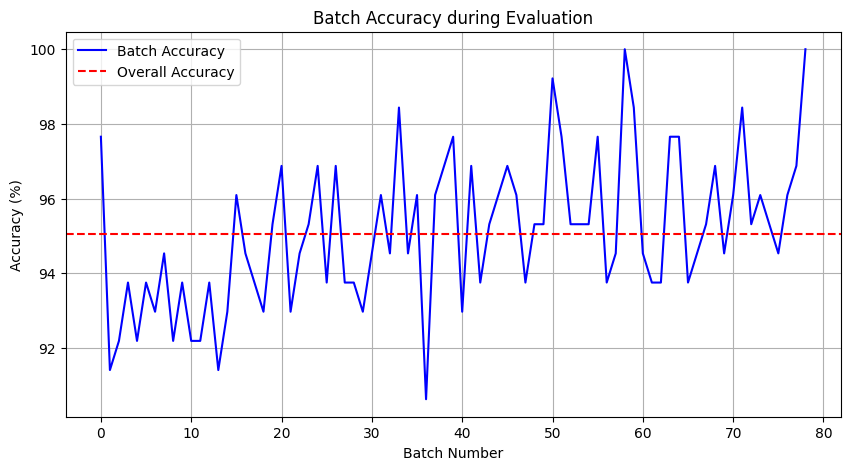

In [8]:
evaluate_model(vgg16, test_loader)

Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 1.91G/1.91G [00:15<00:00, 137MB/s]


Shuffle buffer filling is complete.


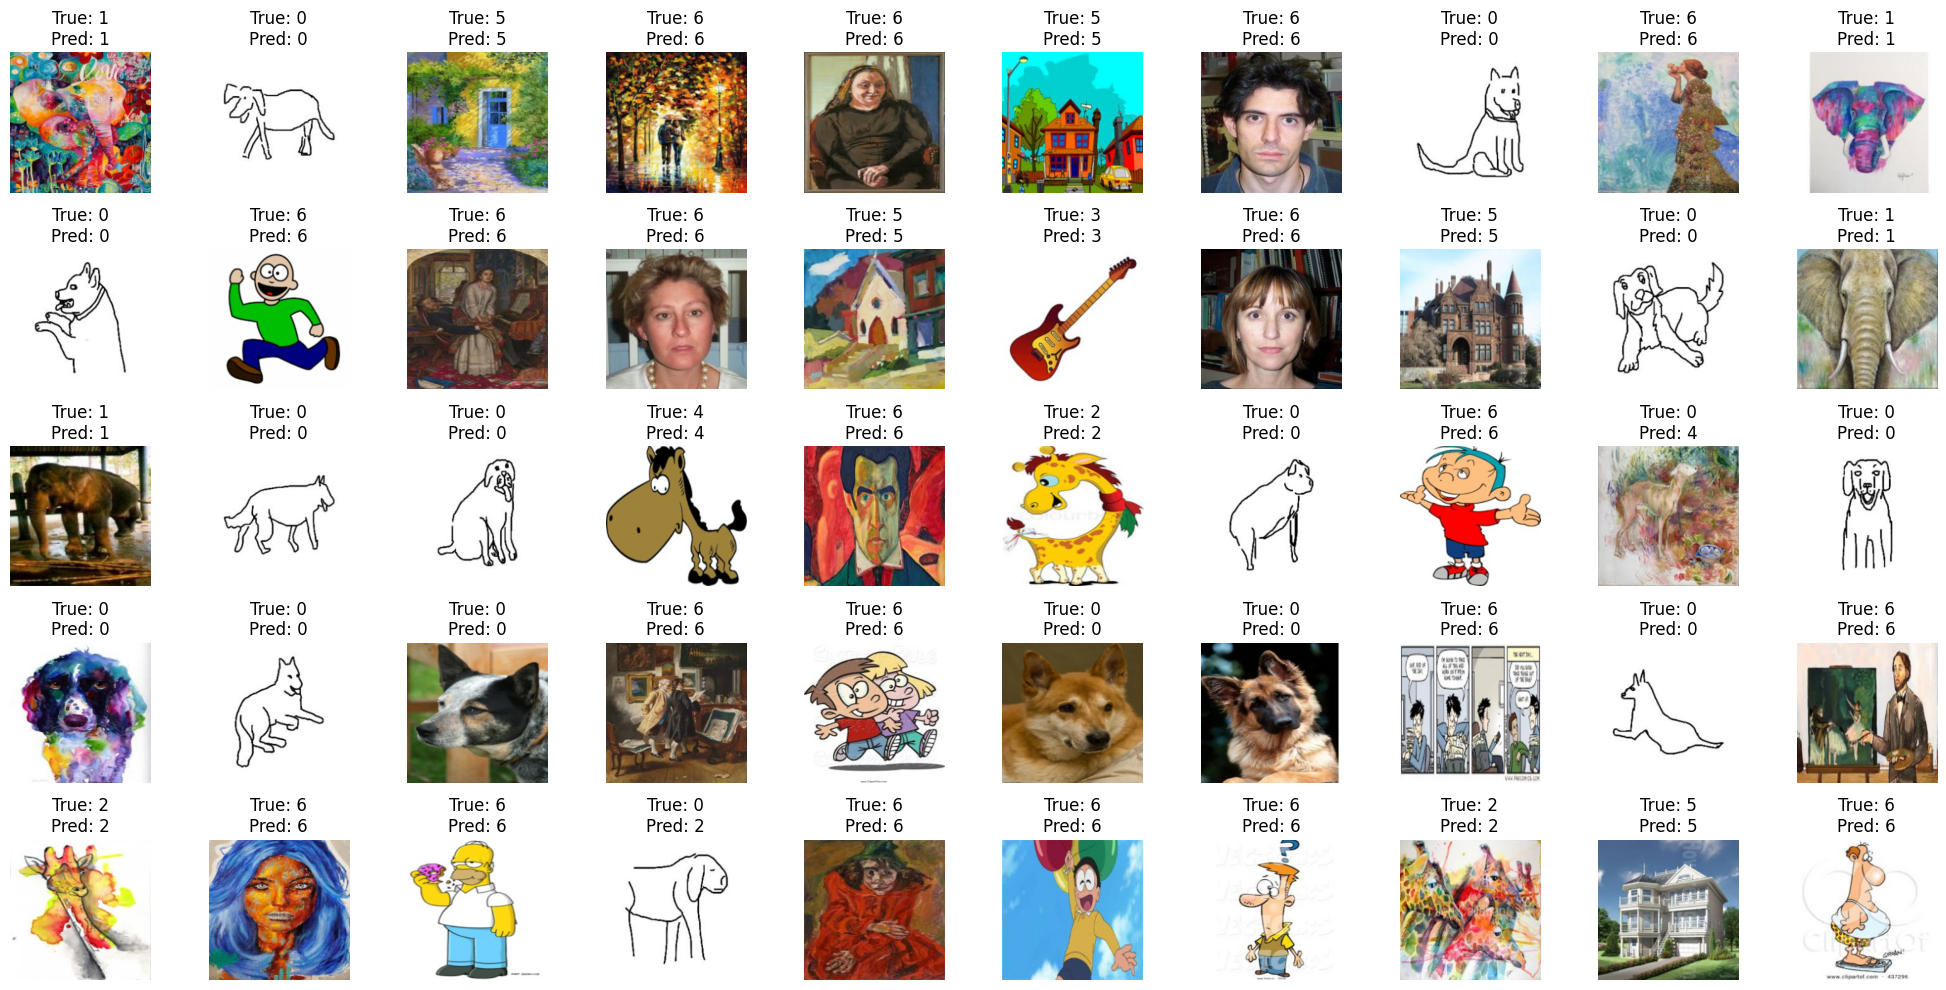

In [12]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

def show_predictions(model, loader, device, num_samples=50, cols=10):
    # Switch model to evaluation mode
    model.eval()

    # Get a batch of data from the loader
    batch = next(iter(loader))
    images, true_labels = batch['images'].to(device), batch['labels'].to(device)

    # If needed, remove the extra dimension in true_labels
    true_labels = true_labels.long().squeeze(1)

    # Get the model's predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

    # Convert tensor to numpy for visualization
    images = images.cpu().numpy()
    true_labels = true_labels.cpu().numpy()
    predicted_labels = predicted_labels.cpu().numpy()

    # Plot the images with predicted and true labels
    rows = math.ceil(num_samples / cols)  # Calculate number of rows based on num_samples and cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i in range(num_samples):
        ax = axes[i]
        img = images[i].transpose((1, 2, 0))  # Change format to HWC for plotting
        img = img * 255.0  # Assuming the images are normalized, revert back to original pixel range
        img = img.astype('uint8')  # Convert to uint8 for display

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")

    # Turn off axes for any extra subplots (if num_samples doesn't fill the grid perfectly)
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Show 50 sample images with their predictions in a grid of 10 columns
show_predictions(vgg16, train_loader, device, num_samples=50, cols=10)


In [14]:
from google.colab import drive
drive.mount('/content/drive')

MODEL_SAVE_PATH = '/content/drive/MyDrive/vgg16_t3_pacs.pth' # Assumes that Google Drive is Mounted and DataSet Uploaded there

torch.save(vgg16.state_dict(), f=MODEL_SAVE_PATH)

MessageError: Error: credential propagation was unsuccessful